# Graph embedding using GloVe
[GloVe embeddings are global embeddings](https://www.aclweb.org/anthology/D14-1162.pdf_). A GloVe model tries to predict, given two elements out of the corpus vocabulary, their cooccurrence frequency.

GloVe model do not scale nicely with the graph size, as the cooccurrence matrix requires to be fully rendered (clearly as a CSR) before the model is trained, hence occupying a significant memory portion on huge graphs.

In [1]:
from embiggen import GloVe
from ensmallen_graph import EnsmallenGraph
from tensorflow.keras.callbacks import EarlyStopping
import silence_tensorflow.auto
import numpy as np
from tensorflow.distribute import MirroredStrategy
from plot_keras_history import plot_history
from plot_keras_history.utils import chain_histories
import os
import pandas as pd

## Loading the graphs
We load the ppi graph as a weighted undirected graph.

In [6]:
graph = EnsmallenGraph.from_csv(
    edge_path="../data/ppi/edges.tsv",
    sources_column="subject",
    destinations_column="object",
    directed=False,
    weights_column="weight"
)

As first thing, we plot a short report showing all the avalable graph details, including the number of edges, nodes, trap nodes and both the connected components and the strongly connected components.

In [3]:
graph.report()

{'selfloops_percentage': '0',
 'unique_edge_types_number': '0',
 'unique_node_types_number': '0',
 'connected_components_number': '181',
 'density': '0.001993564869255138',
 'degrees_mean': '34.25941227814955',
 'singleton_nodes': '0',
 'degrees_mode': '1',
 'is_directed': 'false',
 'bidirectional_percentage': '1',
 'edges_number': '588748',
 'strongly_connected_components_number': '181',
 'degrees_median': '11',
 'nodes_number': '17185',
 'traps_rate': '0'}

## Creating the holdouts
For every one of these examples, we are going to use two experimental setups.

We split the graph into a training and validation components.

Particularly, the training partition will have the same number of connected components as the original graph, while the validation may have more.

We split the two datasets at $0.8$, as done in [Yue et al.](https://academic.oup.com/bioinformatics/article/36/4/1241/5581350).

We are going to us two different experimental setups:

- One, based on the [Yue et al.](https://academic.oup.com/bioinformatics/article/36/4/1241/5581350) and [Leskovec et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5108654/) experimental setups, where we completely separate training negatives from validation negatives and leave the validation parts of the graphs (both positives and negatives) as "holes" in the graph, neither negative nor positive. This may be slighly sconnected from the real scenario, where we cannot remove from a graph part of the validation edges since they are not known. In particular, the negatives edges used in the validation have the same cardinality as the validation positive edges.
- The second one, as close as possible to a real scenario, we will share the negative edges in both the training and validation. In particular in this scenario the validation positive edges appear as negatives during the training, as the assumption made during training with the available data is that any edge that does not appear in the available data is negative.

**For the context of CBOW or GloVe, both setups are the one and the same. The difference is relevant in SkipGram embedding and LinkPrediction.**

### Splitting the graph into the two components

In [4]:
training, validation = graph.holdout(42, 0.8)

The followings are check that are not necessary, but are offered as sanity checks:

In [5]:
assert graph.contains(training + validation)
assert (training + validation).contains(graph)
assert not training.overlaps(validation)
assert not validation.overlaps(training)

### Preparing the experimental setup
For the experimental setup, we are using walk lengths of $100$ nodes, with batch size (number of walks to be considered in each iteration) of $2^{15} = 32768$.

We are going to use 20 walk iterations for each node.

We are going to use a window size of $4$, meaning $4$ nodes on the left and right of every central node. 

Consider that the first *window_size* values on the left and the right of the walks will be trimmed.

To generate the walks we will use the parameters $p$ and $q$ equal to $1.0$.

The *embedding_size* is $100$. For the glove loss, we are going to use an alpha of $0.75$.

We are going to use Nadam as obtimizer. We are going to use an Early Stopping criterion on the *validation loss*, with patience $5$ and delta $0.0001$.

The model will be trained up to $1000$ epochs.

#### Setting up the parameters

In [5]:
batch_size=2**15
walk_length=100
embedding_size=100
iterations=20
window_size=4
p=1.0
q=1.0
patience=5
delta=0.0001
glove_alpha=0.75

#### Creating the training and validation data

In [6]:
train_words, train_contexts, train_labels = training.cooccurence_matrix(
    walk_length,
    window_size=window_size,
    iterations=iterations,
    return_weight=1/p,
    explore_weight=1/q
)

valid_words, valid_contexts, valid_labels = graph.cooccurence_matrix(
    walk_length,
    window_size=window_size,
    iterations=iterations,
    return_weight=1/p,
    explore_weight=1/q
)

## Creating the GloVe model
We are going to setup the model to use, if available, multiple GPUs.

In [7]:
strategy = MirroredStrategy()
with strategy.scope():
    model = GloVe(
        vocabulary_size=training.get_nodes_number(),
        embedding_size=embedding_size,
        alpha=glove_alpha
    )

model.summary()

Model: "GloVe"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words_embedding (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       1718500     words_embedding[0][0]            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       1718500     input_1[0][0]                    
______________________________________________________________________________________________

#### Loading preprocessed model weights
We can optionally load pre-processed model weights, obtained with the very same experimental setup and data, to quickly get through the training step:

In [8]:
model_weights = f"{model.name}_model_weights.h5"

if os.path.exists(model_weights):
    model.load_weights(model_weights)

If a training history is already available, we want to load it to avoid loosing informations:

In [9]:
history = None
training_history_path = f"{model.name}_training_history.csv"

if os.path.exists(training_history_path):
    history = pd.read_csv(training_history_path)

## Tuning the GloVe model

In [11]:
history = chain_histories(
    model.fit(
        (train_words, train_contexts), train_labels,
        validation_data=((valid_words, valid_contexts), valid_labels),
        epochs=1000,
        batch_size=batch_size,
        initial_epoch=0 if history is None else len(history),
        callbacks=[
            EarlyStopping(
                "val_loss",
                min_delta=delta,
                patience=patience
            )
        ]
    ),
    history
)

Epoch 1/1000
826/826 [==============================] - 17s 20ms/step - loss: 0.0377 - val_loss: 0.0155
Epoch 2/1000
826/826 [==============================] - 15s 18ms/step - loss: 0.0083 - val_loss: 0.0063
Epoch 3/1000
826/826 [==============================] - 16s 19ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 4/1000
826/826 [==============================] - 15s 18ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 5/1000
826/826 [==============================] - 15s 18ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/1000
826/826 [==============================] - 15s 18ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 7/1000
826/826 [==============================] - 15s 18ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 8/1000
826/826 [==============================] - 15s 18ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 9/1000
826/826 [==============================] - 15s 18ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 10/1000
826/826 [==============================] - 15s 18m

### Visualizing the training history
We can visualize the performance of the model during the training process as follows:

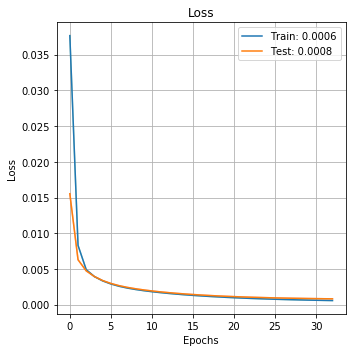

In [12]:
plot_history(history)

There may be some hickups in the plot of the history if the model is reloaded from stored weights: [this is a known Keras issue](https://github.com/keras-team/keras/issues/4875) and is not related to either the holdouts used or the model.

We can save the training history as follows:

In [13]:
history.to_csv(training_history_path, index=False)

## Saving the obtained embeddings
Finally we save our hard earned model embeddings. In another notebook we will show how to do link prediction on the obtained embedding.

In [14]:
np.save(f"{model.name}_embedding.npy", model.embedding)